### Using pre-trained model

Today we're going to build and fine-tune CNN based on weights pre-trained on ImageNet: the largest image classification dataset as of now.
More about imagenet: http://image-net.org/
Setup: classify from a set of 1000 classes.

In [ ]:
import requests

# class labels
LABELS_URL = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
labels = {i: c for i, c in enumerate(requests.get(LABELS_URL).json())}

In [ ]:
print(list(labels.items())[:5])

[(0, 'tench'), (1, 'goldfish'), (2, 'great white shark'), (3, 'tiger shark'), (4, 'hammerhead shark')]


### TorchVision
PyTorch has several companion libraries, one of them being [torchvision](https://github.com/pytorch/vision/tree/master/) - it contains a number of popular vision datasets, preprocessing tools and most importantly, [pre-trained models](https://github.com/pytorch/vision/tree/master/torchvision/models).

For now, we're going to use torch Inception-v3 module.

We're gonna use the inception-v3 network:
![img](https://hackathonprojects.files.wordpress.com/2016/09/googlenet_diagram.png?w=650&h=192)

Let's first look at the code here: [url](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py)

In [ ]:
from torchvision.models.inception import inception_v3

model = inception_v3(pretrained=True,      # load existing weights
                     transform_input=True, # preprocess input image the same way as in training
                    )

model.aux_logits = False # don't predict intermediate logits (yellow layers at the bottom)
model.train(False)

In [ ]:
import torch

dummy_x = torch.randn(5, 3, 299, 299)
model(dummy_x)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor([[-0.9350,  1.0038,  1.8990,  ..., -2.0757, -0.4330,  1.4766],
        [-1.0687,  0.6818,  1.3365,  ..., -2.0965, -0.5218,  1.5230],
        [-1.2509,  0.7810,  1.7044,  ..., -2.2858, -0.4587,  2.0063],
        [-1.1140,  1.1118,  2.1995,  ..., -2.1986, -0.6734,  1.6114],
        [-1.3460,  0.6346,  1.7159,  ..., -2.2466, -0.4981,  1.6590]],
       grad_fn=<AddmmBackward>)

### Predict class probabilities

In [ ]:
# If using Colab
!mkdir sample_images
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/sem4_spring19/week04_finetuning/sample_images/albatross.jpg -O sample_images/albatross.jpg

--2021-10-16 22:47:53--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/sem4_spring19/week04_finetuning/sample_images/albatross.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11607 (11K) [image/jpeg]
Saving to: ‘sample_images/albatross.jpg’

sample_images/albat 100%[===================>]  11.33K  --.-KB/s    in 0s      

2021-10-16 22:47:53 (68.3 MB/s) - ‘sample_images/albatross.jpg’ saved [11607/11607]



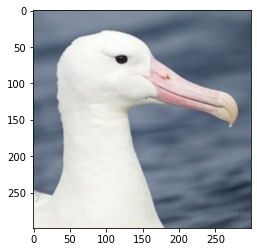

top-10 classes are: 
 [prob : class label]
0.9745 :	albatross
0.0030 :	turnstile
0.0005 :	Shetland Sheepdog
0.0005 :	llama
0.0003 :	collie
0.0003 :	duck
0.0003 :	hammerhead shark
0.0003 :	nipple
0.0003 :	Polaroid camera


In [ ]:
import matplotlib.pyplot as plt
from skimage.transform import resize
%matplotlib inline

img = resize(plt.imread('sample_images/albatross.jpg'), (299, 299))
plt.imshow(img)
plt.show()


def transform_input(img):
    return torch.as_tensor(img.reshape([1, 299, 299, 3]).transpose([0, 3, 1, 2]), dtype=torch.float32)


def predict(img):
    img = transform_input(img)
    
    probs = torch.nn.functional.softmax(model(img), dim=-1)
    
    probs = probs.data.numpy()
    
    top_ix = probs.ravel().argsort()[-1:-10:-1]
    print ('top-10 classes are: \n [prob : class label]')
    for l in top_ix:
        print ('%.4f :\t%s' % (probs.ravel()[l], labels[l].split(',')[0]))
        

predict(img)

### Having fun with pre-trained nets

In [ ]:
!wget http://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg -O img.jpg

--2021-10-16 22:48:01--  http://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg
Resolving cdn.com.do (cdn.com.do)... 104.26.9.119, 104.26.8.119, 172.67.68.26, ...
Connecting to cdn.com.do (cdn.com.do)|104.26.9.119|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg [following]
--2021-10-16 22:48:01--  https://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg
Connecting to cdn.com.do (cdn.com.do)|104.26.9.119|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48606 (47K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  47.47K  --.-KB/s    in 0.01s   

2021-10-16 22:48:01 (4.39 MB/s) - ‘img.jpg’ saved [48606/48606]



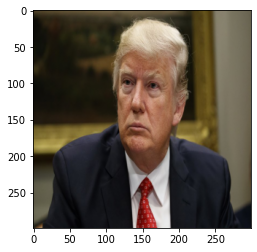

top-10 classes are: 
 [prob : class label]
0.6924 :	suit
0.0912 :	Windsor tie
0.0627 :	bridegroom
0.0045 :	oboe
0.0040 :	academic gown
0.0034 :	slip-on shoe
0.0032 :	wig
0.0028 :	Afghan Hound
0.0027 :	bow tie


In [ ]:
img = resize(plt.imread('img.jpg'), (299, 299))
plt.imshow(img)
plt.show()

predict(img)

# Grand-quest: Dogs Vs Cats
* original competition
* https://www.kaggle.com/c/dogs-vs-cats
* 25k JPEG images of various size, 2 classes (guess what)

### Your main objective
* In this seminar your goal is to fine-tune a pre-trained model to distinguish between the two rivaling animals
* The first step is to just reuse some network layer as features

In [ ]:
!wget -nc https://www.dropbox.com/s/ae1lq6dsfanse76/dogs_vs_cats.train.zip?dl=1 -O data.zip
!unzip -n data.zip

--2021-10-16 22:48:05--  https://www.dropbox.com/s/ae1lq6dsfanse76/dogs_vs_cats.train.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/ae1lq6dsfanse76/dogs_vs_cats.train.zip [following]
--2021-10-16 22:48:05--  https://www.dropbox.com/s/dl/ae1lq6dsfanse76/dogs_vs_cats.train.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 404 Not Found
2021-10-16 22:48:05 ERROR 404: Not Found.

Archive:  data.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of data.zip or
        data.zip.zip, and cannot

In [ ]:
# dropbox link dose't work, read from kaggle and google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp /content/drive/MyDrive/DL_HW4/train.zip ./
!unzip train.zip

### How to get features
During good old days in Torch7 you could access any intermediate output from the sequential model. Nowadays it's a bit more difficult though it's not Tensorflow where you need to compile another model for that. Here we're going to redefine the last layer... yes, to do nothing.

In [ ]:
from copy import deepcopy  # in case you still need original model

embedding = deepcopy(model)

class Identity(torch.nn.Module):

    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        #<YOUR CODE>
        return x
        
    
# redefine the last layer to be Identity
#<YOUR CODE>
embedding.fc = Identity()

assert embedding(transform_input(img)).data.numpy().shape == (1, 2048), "your output for single image should have shape (1, 2048)"

# for starters
* Train sklearn model, evaluate validation accuracy (should be >80%

In [ ]:
#extract features from images
from tqdm import tqdm
import PIL.Image as Image
from imageio import imread
import os
import numpy as np
from tqdm import trange

X = []
Y = []

batch_size = 50 #<YOUR VALUE>
imgs = np.zeros([batch_size, 299, 299, 3])
batch_index = 0

for fname in tqdm(os.listdir('train')):    
    y = fname.startswith("cat")    
    Y.append(y)
    
    img = imread(os.path.join("train", fname))
    
    img = np.array(Image.fromarray(img).resize((299, 299))) / 255.
    imgs[batch_index] = img
    
    if batch_index == batch_size - 1:
        input_tensor = torch.as_tensor(imgs.transpose([0,3,1,2]), dtype=torch.float32)
    
        # use your embedding model to produce feature vector
        with  torch.no_grad():
            #vectors = []
            for i in trange(len(input_tensor)):
                #vectors.append(embedding(input_tensor[i : i+1]))
                features =  embedding(input_tensor[i : i+1])
                X.append(features)        
        batch_index = 0
        continue
        
    batch_index += 1

In [ ]:
X = np.concatenate(X) #stack all [1xfeatures] matrices into one. 
assert X.ndim == 2
#WARNING! the concatenate works for [1xN] matrices. If you have other format, stack them yourself.

#crop if we ended prematurely
Y = np.array(Y[:len(X)])

print(X.shape, Y.shape)

(2560, 2048) (2560,)


In [ ]:
#<split data here or use cross-validation>
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print(X.shape)
print(x_train.shape)
print(x_test.shape)

(2560, 2048)
(2048, 2048)
(512, 2048)


__load our dakka__
![img](https://s-media-cache-ak0.pinimg.com/564x/80/a1/81/80a1817a928744a934a7d32e7c03b242.jpg)

In [ ]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn import metrics

In [ ]:
model = RandomForestClassifier()
model = model.fit(x_train, y_train)
metrics.accuracy_score(y_test, model.predict(x_test))

0.97265625

In [ ]:
model = ExtraTreesClassifier()
model = model.fit(x_train, y_train)
metrics.accuracy_score(y_test, model.predict(x_test))

0.970703125

In [ ]:
model = GradientBoostingClassifier()
model = model.fit(x_train, y_train)
metrics.accuracy_score(y_test, model.predict(x_test))

0.984375

In [ ]:
model = AdaBoostClassifier()
model = model.fit(x_train, y_train)
metrics.accuracy_score(y_test, model.predict(x_test))

0.970703125

In [ ]:
model = LogisticRegression()
model = model.fit(x_train, y_train)
metrics.accuracy_score(y_test, model.predict(x_test))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.982421875

In [ ]:
model = RidgeClassifier()
model = model.fit(x_train, y_train)
metrics.accuracy_score(y_test, model.predict(x_test))

0.9765625

In [ ]:
model = SVC()
model = model.fit(x_train, y_train)
metrics.accuracy_score(y_test, model.predict(x_test))

0.984375

In [ ]:
model = DecisionTreeClassifier()
model = model.fit(x_train, y_train)
metrics.accuracy_score(y_test, model.predict(x_test))

0.953125

# Main quest

* Get the score improved!
* You have to reach __at least 95%__ on the test set. More = better.

No methods are illegal: ensembling, data augmentation, NN hacks. 
Just don't let test data slip into training.


### Split the raw image data
  * please do train/validation/test instead of just train/test
  * reasonable but not optimal split is 20k/2.5k/2.5k or 15k/5k/5k

### Build a few layers on top of chosen "neck" layers.
  * a good idea is to just stack more layers inside the same network
  * alternative: stack on top of get_output

### Train the newly added layers for some iterations
  * you can selectively train some weights by sending the correct parameters in the optimizer
      * `opt = torch.optim.Adam([head_only.parameters()])``
  * it's cruicial to monitor the network performance at this and following steps

### Fine-tune the network body
  * probably a good idea to SAVE your new network weights now 'cuz it's easy to mess things up.
  * Moreover, saving weights periodically is a no-nonsense idea
  * even more cruicial to monitor validation performance
  * main network body may need a separate, much lower learning rate

In [ ]:
import time
from os import listdir
from os.path import isfile, join
import shutil
import numpy as np
from torchvision import transforms
from torchvision import datasets
import torch.nn.functional as F
import torchvision.models
import torch, torch.nn as nn
from tqdm import tqdm

In [ ]:
!mkdir validation
!mkdir test
files = [f for f in listdir('./train') if(isfile(join('./train', f)) and f.endswith('.jpg'))]  
# train to validation
for f in np.random.choice(files, 5000, replace=False):
    shutil.move(f'./train/{f}', f'./validation/{f}')       
    files.remove(f)
# train to test
for f in np.random.choice(files, 5000, replace=False):
    shutil.move(f'./train/{f}', f'./test/{f}')

In [ ]:
print(f"train size is: {len([f for f in listdir('./train') if f.endswith('.jpg')])}")
print(f"validation size is: {len([f for f in listdir('./validation') if f.endswith('.jpg')])}")
print(f"test size is: {len([f for f in listdir('./test') if f.endswith('.jpg')])}")

train size is: 15000
validation size is: 5000
test size is: 5000


In [ ]:
!mkdir ./train/cat; mv ./train/cat*.jpg ./train/cat/
!mkdir ./train/dog; mv ./train/dog*.jpg ./train/dog/
!mkdir ./validation/cat; mv ./validation/cat*.jpg ./validation/cat/
!mkdir ./validation/dog; mv ./validation/dog*.jpg ./validation/dog/
!mkdir ./test/cat; mv ./test/cat*.jpg ./test/cat/
!mkdir ./test/dog; mv ./test/dog*.jpg ./test/dog/

In [ ]:
means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2023, 0.1994, 0.2010))

transform_augment = transforms.Compose([
#    transforms.RandomCrop(32, padding=4),
#    transforms.RandomRotation([-30, 30]),
#    transforms.RandomHorizontalFlip(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

In [ ]:
train_loader = datasets.ImageFolder(root="./train/",transform = transform_augment)
validation_loader = datasets.ImageFolder(root="./validation/",transform = transform_test)
test_loader = datasets.ImageFolder(root="./test/",transform = transform_test)

In [ ]:
train_batch_gen = torch.utils.data.DataLoader(train_loader,
                                              batch_size=124,
                                              shuffle=True,
                                              num_workers=1)
validation_batch_gen = torch.utils.data.DataLoader(validation_loader,
                                              batch_size=124,
                                              shuffle=True,
                                              num_workers=1)
test_batch_gen = torch.utils.data.DataLoader(test_loader,
                                              batch_size=124,
                                              shuffle=True,
                                              num_workers=1)

In [ ]:
device = torch.device("cuda:0")

In [ ]:
model = torchvision.models.resnet18(pretrained = True)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

model = model.to(device)

opt = torch.optim.Adam(model.parameters(), lr=0.0001)

train_loss = []
val_loss = []
val_accuracy = []

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
def compute_loss(X_batch, y_batch):
    X_batch = torch.as_tensor(X_batch, dtype=torch.float32)
    y_batch = torch.as_tensor(y_batch, dtype=torch.int64)
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [ ]:
num_epochs = 1
batch_size = 124

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    bach_counter = 0
    for (x_batch, y_batch) in tqdm(train_batch_gen):
        # train on batch

        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        loss = compute_loss(x_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.cpu().numpy())
        bach_counter += 1

    # Validation
    model.train(False) # disable dropout / use averages for batch_norm
    for (x_batch, y_batch) in tqdm(validation_batch_gen):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        logits = model(torch.as_tensor(x_batch, dtype=torch.float32))
        loss = compute_loss(x_batch, y_batch)

        y_pred = logits.max(1)[1].data.cpu().numpy()
        val_loss.append(loss.data.cpu().numpy())
        val_accuracy.append(np.mean(y_batch.cpu().numpy() == y_pred))


100%|██████████| 41/41 [00:35<00:00,  1.14it/s]


In [ ]:
print("validation accuracy:\t\t{:.2f} %".format(np.mean(val_accuracy) * 100))

validation accuracy:		98.78 %


In [ ]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for (x_batch, y_batch) in tqdm(test_batch_gen):
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    logits = model(torch.as_tensor(x_batch, dtype=torch.float32))
    y_pred = logits.max(1)[1].data.cpu().numpy()
    test_batch_acc.append(np.mean(y_batch.cpu().numpy() == y_pred))

test_accuracy = np.mean(test_batch_acc)    
print("test accuracy:\t\t{:.2f} %".format(test_accuracy * 100))

100%|██████████| 41/41 [00:32<00:00,  1.27it/s]

test accuracy:		98.52 %


# Bonus: #deepdream

https://twitter.com/search?q=%23deepdream&src=typd

Code is heavily based on https://github.com/thesemicolonguy/deep-dream-pytorch

Original blogpost where more ideas can be taken from: https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html

In [ ]:
from PIL import Image, ImageFilter, ImageChops
from torchvision import transforms
import numpy as np

In [ ]:
modulelist = list(model.children())

In [ ]:
preprocess = transforms.Compose([
#    transforms.Resize((299, 299)),  # do we really need this now?
    transforms.ToTensor()#,
    ])


def dd_helper(image, layer, iterations, lr):
    input_var = torch.as_tensor(preprocess(image).unsqueeze(0), requires_grad=True, dtype=torch.float32)
    model.zero_grad()
    for i in range(iterations):
        out = input_var
        for j in range(layer):
            out = modulelist[j](out)
        loss = out.norm()
        loss.backward()
        input_var.data = input_var.data + lr * input_var.grad.data
    
    input_im = input_var.data.squeeze()
    input_im.transpose_(0, 1)
    input_im.transpose_(1, 2)
    input_im = np.clip(input_im, 0, 1)
    im = Image.fromarray(np.uint8(input_im * 255))
    return im

In [ ]:
def deep_dream(image, layer, iterations, lr, octave_scale, num_octaves):
    if num_octaves>0:
        image1 = image.filter(ImageFilter.GaussianBlur(2))
        if (image1.size[0] / octave_scale < 1 or image1.size[1] / octave_scale < 1):
            size = image1.size
        else:
            size = (int(image1.size[0] / octave_scale), int(image1.size[1] / octave_scale))
            
        image1 = image1.resize(size, Image.ANTIALIAS)
        image1 = deep_dream(image1, layer, iterations, lr, octave_scale, num_octaves-1)
        size = (image.size[0], image.size[1])
        image1 = image1.resize(size, Image.ANTIALIAS)
        image = ImageChops.blend(image, image1, 0.6)
    print("-------------- Recursive level: ", num_octaves, '--------------')
    img_result = dd_helper(image, layer, iterations, lr)
    img_result = img_result.resize(image.size)
    plt.imshow(img_result)
    return img_result

In [ ]:
img = Image.fromarray(plt.imread('img.jpg'))
img

In [ ]:
output = deep_dream(img, 5, 5, 0.3, 2, 20)

In [ ]:
output = deep_dream(img, 12, 5, 0.2, 2, 1)

In [ ]:
#can you implement one class probability optimization to make model dream about bananas
<YOUR CODE>

# Bonus 2: Adversarial Attack

Original PyTorch tutorial is [here](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html)

In [ ]:
# Change the Deep Dream step function
# to make it doing adversarial example from original image


def dd_helper_modified(image, layer, iterations, lr):
    input_var = torch.as_tensor(preprocess(image).unsqueeze(0), requires_grad=True, dtype=torch.float32)
    model.zero_grad()
    for i in range(iterations):
        out = input_var
        for j in range(layer):  # maybe change this
            out = modulelist[j](out)
        loss = out.norm()
        loss.backward()
        input_var.data = input_var.data + lr * input_var.grad.data # and probably this
    input_im = input_var.data.squeeze()
    input_im.transpose_(0, 1)
    input_im.transpose_(1, 2)
    input_im = np.clip(input_im, 0, 1)
    im = Image.fromarray(np.uint8(input_im * 255))
    return im

In [ ]:
img = Image.fromarray(plt.imread('img.jpg'))
img_adv = dd_helper(img, ?, ?, ?)
img_adv

In [ ]:
predict(resize(np.asarray(img_adv), (299, 299)))